In [1]:
%load_ext autoreload
%autoreload 2

from cffi import FFI
import os

ffi = FFI()
ffi.cdef("""
/* from stdio.h */
FILE* fopen(const char* path, const char* mode);
int fclose(FILE* fp);
FILE* stderr;  /* GNU C library */
FILE* __stderrp;  /* Mac OS X */
""")
try:
    stdio = ffi.dlopen(None)
    devnull = stdio.fopen(os.devnull.encode(), b'w')
except OSError:
    pass
try:
    stdio.stderr = devnull
except KeyError:
    try:
        stdio.__stderrp = devnull
    except KeyError:
        stdio.fclose(devnull)

/opt/conda/lib/python3.7/site-packages/cffi/cparser.py:165: UserWarning: Global variable 'stderr' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  "(usually 'extern')" % (decl.name,))
/opt/conda/lib/python3.7/site-packages/cffi/cparser.py:165: UserWarning: Global variable '__stderrp' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  "(usually 'extern')" % (decl.name,))


In [2]:
# General
import sys
sys.path.insert(0, '/content/highway-env/scripts/')
import io
import base64
import os
from tqdm.notebook import trange
import numpy as np
import random
import math
import pygame
import json
import ast
from pprint import pprint 
import glob
from collections import Counter
import datetime

# Local
from final_project.display_utils import wrap_env, show_video
from models.agent import Agent

# Gym Env
import gym
import highway_env
# from utils import record_videos, show_videos
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Visualization
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay

%load_ext tensorboard
%matplotlib inline

pygame 2.1.2 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

In [4]:
agent = Agent()
score_history = agent.play()


Episode: 0, Best Average Score 362.63734561935803, Average Score: 362.63734561935803, Best Score: 362.63734561935803, Steps: 500 

Action Count: Counter({4: 400, 1: 45, 3: 41, 2: 10, 0: 4}), Time: 2022-07-22 11:16:00.523074



Episode: 1, Best Average Score 368.06503571021494, Average Score: 368.06503571021494, Best Score: 373.49272580107186, Steps: 500 

Action Count: Counter({4: 376, 3: 53, 1: 50, 2: 18, 0: 3}), Time: 2022-07-22 11:16:20.603878



Episode: 2, Best Average Score 368.06503571021494, Average Score: 261.3787051460401, Best Score: 373.49272580107186, Steps: 68 

Action Count: Counter({4: 53, 1: 7, 3: 6, 2: 2}), Time: 2022-07-22 11:16:24.513148



Episode: 3, Best Average Score 368.06503571021494, Average Score: 208.45248641562387, Best Score: 373.49272580107186, Steps: 67 

Action Count: Counter({4: 44, 1: 11, 3: 9, 2: 3}), Time: 2022-07-22 11:16:28.254622



Episode: 4, Best Average Score 368.06503571021494, Average Score: 182.04883925065417, Best Score: 373.49272580107

In [9]:
# agent.score_history

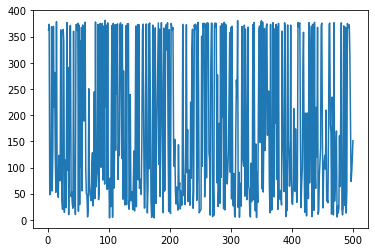

In [11]:
x = [i+1 for i in range(len(agent.score_history))]

plt.plot(x, agent.score_history)


Text(0.5, 1.0, 'Running average of previous 100 scores')

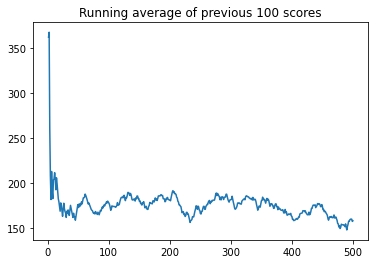

In [12]:
running_avg = np.zeros(len(agent.score_history))
for i in range(len(running_avg)):
    running_avg[i] = np.mean(agent.score_history[max(0, i-100):(i+1)])
plt.plot(x, running_avg)
plt.title('Running average of previous 100 scores')
# plt.savefig(figure_file)
    